In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from torchvision import datasets, models
from torch.utils.data import Subset
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
config = {"batch_size": 64, "epochs": 10, "learning_rate": 0.01}

class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

trainset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
testset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=config["batch_size"], shuffle=True
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=config["batch_size"], shuffle=False
)

model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

Files already downloaded and verified
Files already downloaded and verified


#### 100% размеченной выборки

In [4]:
@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    val_loss = 0
    all_labels = []
    all_preds = []
    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
    val_loss /= len(dataloader)
    return val_loss, all_labels, all_preds


# Инициализация для хранения метрик
train_losses = []
val_losses = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1s = []
val_f1s = []

# Тренировка модели
for epoch in range(config["epochs"]):
    model.train()
    running_loss = 0.0
    all_train_labels = []
    all_train_preds = []

    for images, labels in trainloader:
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(outputs.argmax(dim=1).cpu().numpy())

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # Расчет метрик на обучении
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
        all_train_labels, all_train_preds, average="weighted"
    )
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    # Оценка на валидационном наборе
    val_loss, all_labels, all_preds = evaluate(model, testloader)
    val_losses.append(val_loss)

    # Расчет метрик на валидации
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted"
    )
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    print(
        f"Epoch [{epoch + 1}/{config['epochs']}], "
        f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
    )

Epoch [1/10], Train Loss: 1.7249, Val Loss: 1.4270
Epoch [2/10], Train Loss: 1.1936, Val Loss: 1.0494
Epoch [3/10], Train Loss: 0.9564, Val Loss: 0.9707
Epoch [4/10], Train Loss: 0.8147, Val Loss: 0.8544
Epoch [5/10], Train Loss: 0.6988, Val Loss: 0.8078
Epoch [6/10], Train Loss: 0.5976, Val Loss: 0.8510
Epoch [7/10], Train Loss: 0.5082, Val Loss: 0.8147
Epoch [8/10], Train Loss: 0.4252, Val Loss: 0.8242
Epoch [9/10], Train Loss: 0.3495, Val Loss: 0.8458
Epoch [10/10], Train Loss: 0.2839, Val Loss: 0.9116


In [5]:
# Функция для оценки модели
@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    val_loss = 0
    all_labels = []
    all_preds = []
    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())

    # Средняя потеря
    val_loss /= len(dataloader)

    # Расчет метрик для каждого класса (точность, полнота, F1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None, labels=range(10)
    )

    return val_loss, precision, recall, f1


# После завершения обучения, например, после всех эпох:
model.eval()  # Переводим модель в режим оценки (выключает Dropout, BatchNorm)
val_loss, precision, recall, f1 = evaluate(model, testloader)

# Выводим метрики для каждого класса
print("Metrics for each class:")
for i, class_name in enumerate(class_names):
    print(
        f"{class_name} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1[i]:.4f}"
    )

Metrics for each class:
airplane - Precision: 0.7779, Recall: 0.7740, F1: 0.7759
automobile - Precision: 0.8716, Recall: 0.8010, F1: 0.8348
bird - Precision: 0.6459, Recall: 0.7060, F1: 0.6746
cat - Precision: 0.5220, Recall: 0.6280, F1: 0.5701
deer - Precision: 0.7497, Recall: 0.7070, F1: 0.7277
dog - Precision: 0.6444, Recall: 0.5980, F1: 0.6203
frog - Precision: 0.8012, Recall: 0.8060, F1: 0.8036
horse - Precision: 0.8339, Recall: 0.7680, F1: 0.7996
ship - Precision: 0.8825, Recall: 0.8040, F1: 0.8414
truck - Precision: 0.7863, Recall: 0.8500, F1: 0.8169


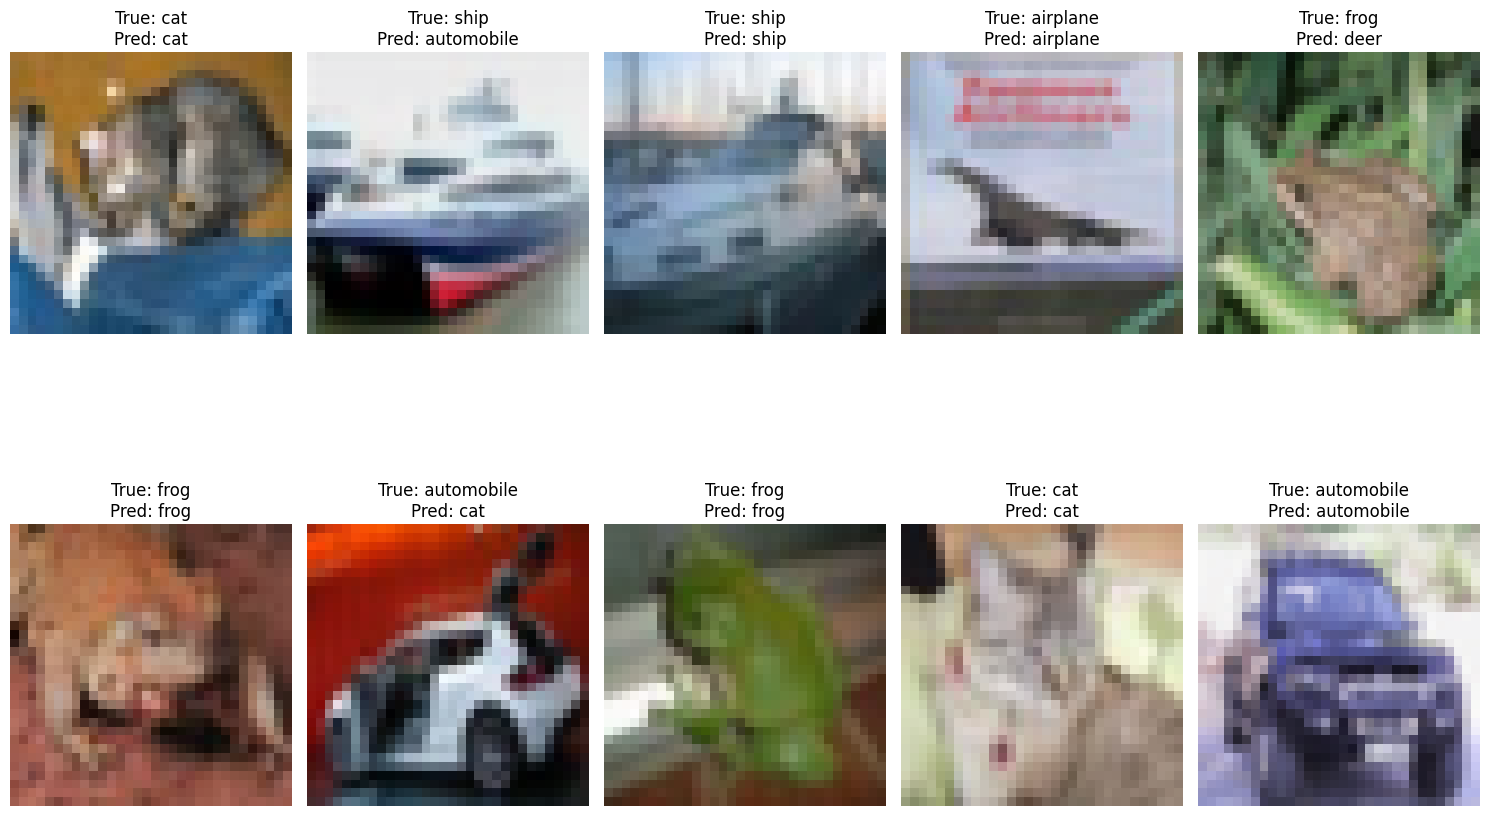

In [6]:
@torch.no_grad()
def visualize_predictions(model, dataloader, num_images=10):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 15))

    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        for i in range(images.size(0)):
            if images_shown >= num_images:
                break

            image = images[i].cpu().numpy().transpose((1, 2, 0))
            image = np.clip(
                image * np.array([0.229, 0.224, 0.225])
                + np.array([0.485, 0.456, 0.406]),
                0,
                1,
            )
            label = class_names[labels[i].item()]
            pred = class_names[preds[i].item()]

            plt.subplot(num_images // 5 + 1, 5, images_shown + 1)
            plt.imshow(image)
            plt.title(f"True: {label}\nPred: {pred}")
            plt.axis("off")
            images_shown += 1

        if images_shown >= num_images:
            break

    plt.tight_layout()
    plt.show()


visualize_predictions(model, testloader, num_images=10)

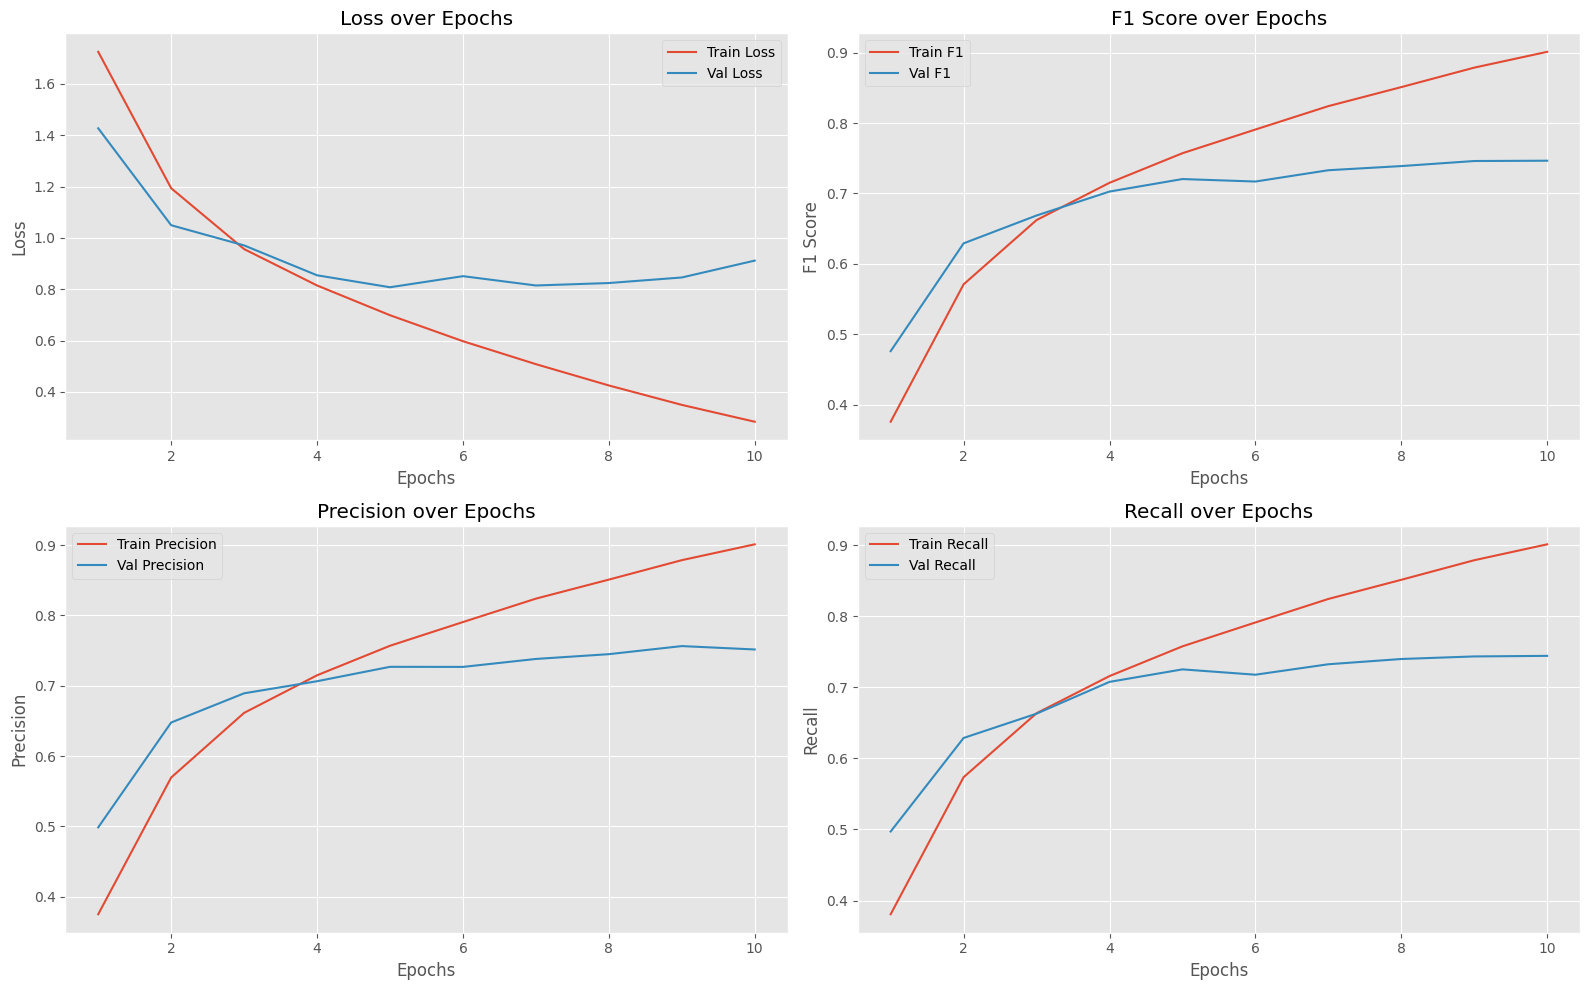

In [7]:
plt.style.use("ggplot")

# Построение графиков
epochs = range(1, config["epochs"] + 1)

plt.figure(figsize=(16, 10))

# График потерь
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# График F1-score
plt.subplot(2, 2, 2)
plt.plot(epochs, train_f1s, label="Train F1")
plt.plot(epochs, val_f1s, label="Val F1")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("F1 Score over Epochs")
plt.legend()

# График Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, train_precisions, label="Train Precision")
plt.plot(epochs, val_precisions, label="Val Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Precision over Epochs")
plt.legend()

# График Recall
plt.subplot(2, 2, 4)
plt.plot(epochs, train_recalls, label="Train Recall")
plt.plot(epochs, val_recalls, label="Val Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Recall over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

#### 50% размеченной выборки

In [8]:
train_size = len(trainset) // 2
train_indices = np.random.choice(len(trainset), train_size, replace=False)
train_subset = Subset(trainset, train_indices)

test_size = len(testset) // 2
test_indices = np.random.choice(len(testset), test_size, replace=False)
test_subset = Subset(testset, test_indices)

trainloader = torch.utils.data.DataLoader(
    train_subset, batch_size=config["batch_size"], shuffle=True
)
testloader = torch.utils.data.DataLoader(
    test_subset, batch_size=config["batch_size"], shuffle=False
)

In [9]:
@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    val_loss = 0
    all_labels = []
    all_preds = []
    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
    val_loss /= len(dataloader)
    return val_loss, all_labels, all_preds


# Инициализация для хранения метрик
train_losses = []
val_losses = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1s = []
val_f1s = []

# Тренировка модели
for epoch in range(config["epochs"]):
    model.train()
    running_loss = 0.0
    all_train_labels = []
    all_train_preds = []

    for images, labels in trainloader:
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(outputs.argmax(dim=1).cpu().numpy())

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # Расчет метрик на обучении
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
        all_train_labels, all_train_preds, average="weighted"
    )
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    # Оценка на валидационном наборе
    val_loss, all_labels, all_preds = evaluate(model, testloader)
    val_losses.append(val_loss)

    # Расчет метрик на валидации
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted"
    )
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    print(
        f"Epoch [{epoch + 1}/{config['epochs']}], "
        f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
    )

Epoch [1/10], Train Loss: 0.2315, Val Loss: 0.9789
Epoch [2/10], Train Loss: 0.1611, Val Loss: 1.0769
Epoch [3/10], Train Loss: 0.1341, Val Loss: 1.1803
Epoch [4/10], Train Loss: 0.1262, Val Loss: 1.2438
Epoch [5/10], Train Loss: 0.1059, Val Loss: 1.1638
Epoch [6/10], Train Loss: 0.0930, Val Loss: 1.3614
Epoch [7/10], Train Loss: 0.1020, Val Loss: 1.2745
Epoch [8/10], Train Loss: 0.0811, Val Loss: 1.3301
Epoch [9/10], Train Loss: 0.0801, Val Loss: 1.3564
Epoch [10/10], Train Loss: 0.0773, Val Loss: 1.3376


In [10]:
# Функция для оценки модели
@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    val_loss = 0
    all_labels = []
    all_preds = []
    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())

    # Средняя потеря
    val_loss /= len(dataloader)

    # Расчет метрик для каждого класса (точность, полнота, F1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None, labels=range(10)
    )

    return val_loss, precision, recall, f1


# После завершения обучения, например, после всех эпох:
model.eval()  # Переводим модель в режим оценки (выключает Dropout, BatchNorm)
val_loss, precision, recall, f1 = evaluate(model, testloader)

# Выводим метрики для каждого класса
print("Metrics for each class:")
for i, class_name in enumerate(class_names):
    print(
        f"{class_name} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1[i]:.4f}"
    )

Metrics for each class:
airplane - Precision: 0.7804, Recall: 0.7743, F1: 0.7773
automobile - Precision: 0.8146, Recall: 0.8429, F1: 0.8285
bird - Precision: 0.6881, Recall: 0.5996, F1: 0.6408
cat - Precision: 0.5665, Recall: 0.4991, F1: 0.5307
deer - Precision: 0.6776, Recall: 0.7004, F1: 0.6888
dog - Precision: 0.5774, Recall: 0.6725, F1: 0.6214
frog - Precision: 0.7247, Recall: 0.8337, F1: 0.7754
horse - Precision: 0.8473, Recall: 0.7614, F1: 0.8021
ship - Precision: 0.8560, Recall: 0.8474, F1: 0.8517
truck - Precision: 0.8231, Recall: 0.8118, F1: 0.8174


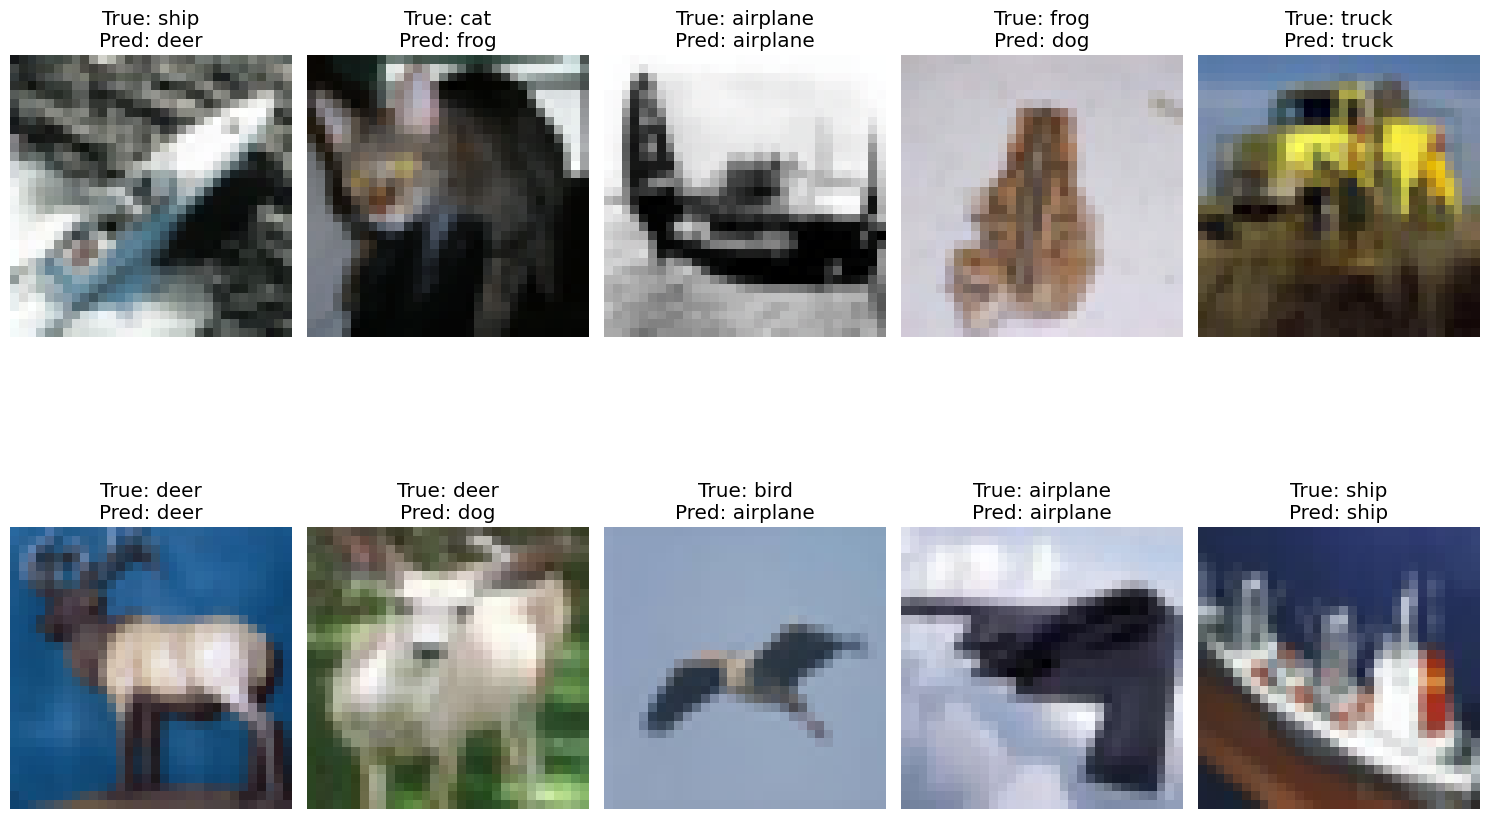

In [11]:
@torch.no_grad()
def visualize_predictions(model, dataloader, num_images=10):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 15))

    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        for i in range(images.size(0)):
            if images_shown >= num_images:
                break

            image = images[i].cpu().numpy().transpose((1, 2, 0))
            image = np.clip(
                image * np.array([0.229, 0.224, 0.225])
                + np.array([0.485, 0.456, 0.406]),
                0,
                1,
            )
            label = class_names[labels[i].item()]
            pred = class_names[preds[i].item()]

            plt.subplot(num_images // 5 + 1, 5, images_shown + 1)
            plt.imshow(image)
            plt.title(f"True: {label}\nPred: {pred}")
            plt.axis("off")
            images_shown += 1

        if images_shown >= num_images:
            break

    plt.tight_layout()
    plt.show()


visualize_predictions(model, testloader, num_images=10)

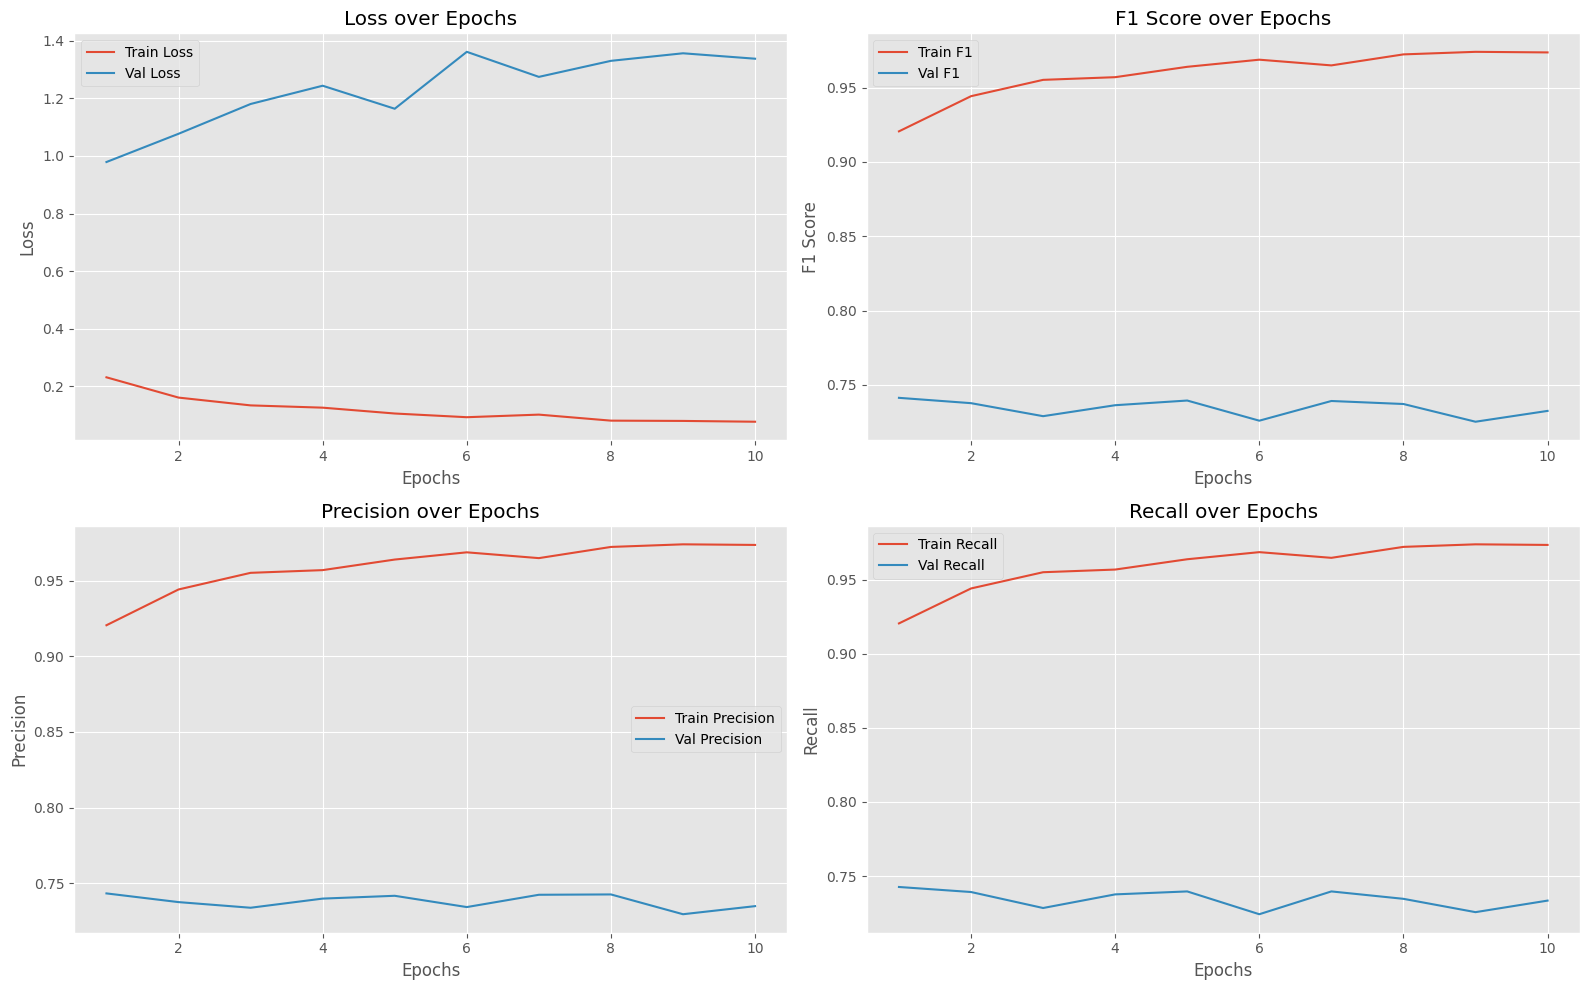

In [12]:
plt.style.use("ggplot")

# Построение графиков
epochs = range(1, config["epochs"] + 1)

plt.figure(figsize=(16, 10))

# График потерь
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# График F1-score
plt.subplot(2, 2, 2)
plt.plot(epochs, train_f1s, label="Train F1")
plt.plot(epochs, val_f1s, label="Val F1")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("F1 Score over Epochs")
plt.legend()

# График Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, train_precisions, label="Train Precision")
plt.plot(epochs, val_precisions, label="Val Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Precision over Epochs")
plt.legend()

# График Recall
plt.subplot(2, 2, 4)
plt.plot(epochs, train_recalls, label="Train Recall")
plt.plot(epochs, val_recalls, label="Val Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Recall over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

#### 10% размеченной выборки

In [13]:
train_size = len(trainset) // 10
train_indices = np.random.choice(len(trainset), train_size, replace=False)
train_subset = Subset(trainset, train_indices)

test_size = len(testset) // 10
test_indices = np.random.choice(len(testset), test_size, replace=False)
test_subset = Subset(testset, test_indices)

trainloader = torch.utils.data.DataLoader(
    train_subset, batch_size=config["batch_size"], shuffle=True
)
testloader = torch.utils.data.DataLoader(
    test_subset, batch_size=config["batch_size"], shuffle=False
)

In [14]:
@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    val_loss = 0
    all_labels = []
    all_preds = []
    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
    val_loss /= len(dataloader)
    return val_loss, all_labels, all_preds


# Инициализация для хранения метрик
train_losses = []
val_losses = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1s = []
val_f1s = []

# Тренировка модели
for epoch in range(config["epochs"]):
    model.train()
    running_loss = 0.0
    all_train_labels = []
    all_train_preds = []

    for images, labels in trainloader:
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(outputs.argmax(dim=1).cpu().numpy())

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # Расчет метрик на обучении
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
        all_train_labels, all_train_preds, average="weighted"
    )
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    # Оценка на валидационном наборе
    val_loss, all_labels, all_preds = evaluate(model, testloader)
    val_losses.append(val_loss)

    # Расчет метрик на валидации
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted"
    )
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    print(
        f"Epoch [{epoch + 1}/{config['epochs']}], "
        f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
    )

Epoch [1/10], Train Loss: 0.3486, Val Loss: 0.8828
Epoch [2/10], Train Loss: 0.1796, Val Loss: 1.0511
Epoch [3/10], Train Loss: 0.0772, Val Loss: 1.2361
Epoch [4/10], Train Loss: 0.0802, Val Loss: 1.3830
Epoch [5/10], Train Loss: 0.0674, Val Loss: 1.3505
Epoch [6/10], Train Loss: 0.0352, Val Loss: 1.3489
Epoch [7/10], Train Loss: 0.1328, Val Loss: 1.4014
Epoch [8/10], Train Loss: 0.0298, Val Loss: 1.4632
Epoch [9/10], Train Loss: 0.0161, Val Loss: 1.5144
Epoch [10/10], Train Loss: 0.0626, Val Loss: 1.5193


In [15]:
# Функция для оценки модели
@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    val_loss = 0
    all_labels = []
    all_preds = []
    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())

    # Средняя потеря
    val_loss /= len(dataloader)

    # Расчет метрик для каждого класса (точность, полнота, F1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None, labels=range(10)
    )

    return val_loss, precision, recall, f1


# После завершения обучения, например, после всех эпох:
model.eval()  # Переводим модель в режим оценки (выключает Dropout, BatchNorm)
val_loss, precision, recall, f1 = evaluate(model, testloader)

# Выводим метрики для каждого класса
print("Metrics for each class:")
for i, class_name in enumerate(class_names):
    print(
        f"{class_name} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1[i]:.4f}"
    )

Metrics for each class:
airplane - Precision: 0.7647, Recall: 0.7879, F1: 0.7761
automobile - Precision: 0.7604, Recall: 0.7849, F1: 0.7725
bird - Precision: 0.7143, Recall: 0.5882, F1: 0.6452
cat - Precision: 0.5437, Recall: 0.5437, F1: 0.5437
deer - Precision: 0.7895, Recall: 0.6383, F1: 0.7059
dog - Precision: 0.5726, Recall: 0.6979, F1: 0.6291
frog - Precision: 0.7273, Recall: 0.8421, F1: 0.7805
horse - Precision: 0.8252, Recall: 0.7944, F1: 0.8095
ship - Precision: 0.8298, Recall: 0.8387, F1: 0.8342
truck - Precision: 0.8435, Recall: 0.8220, F1: 0.8326


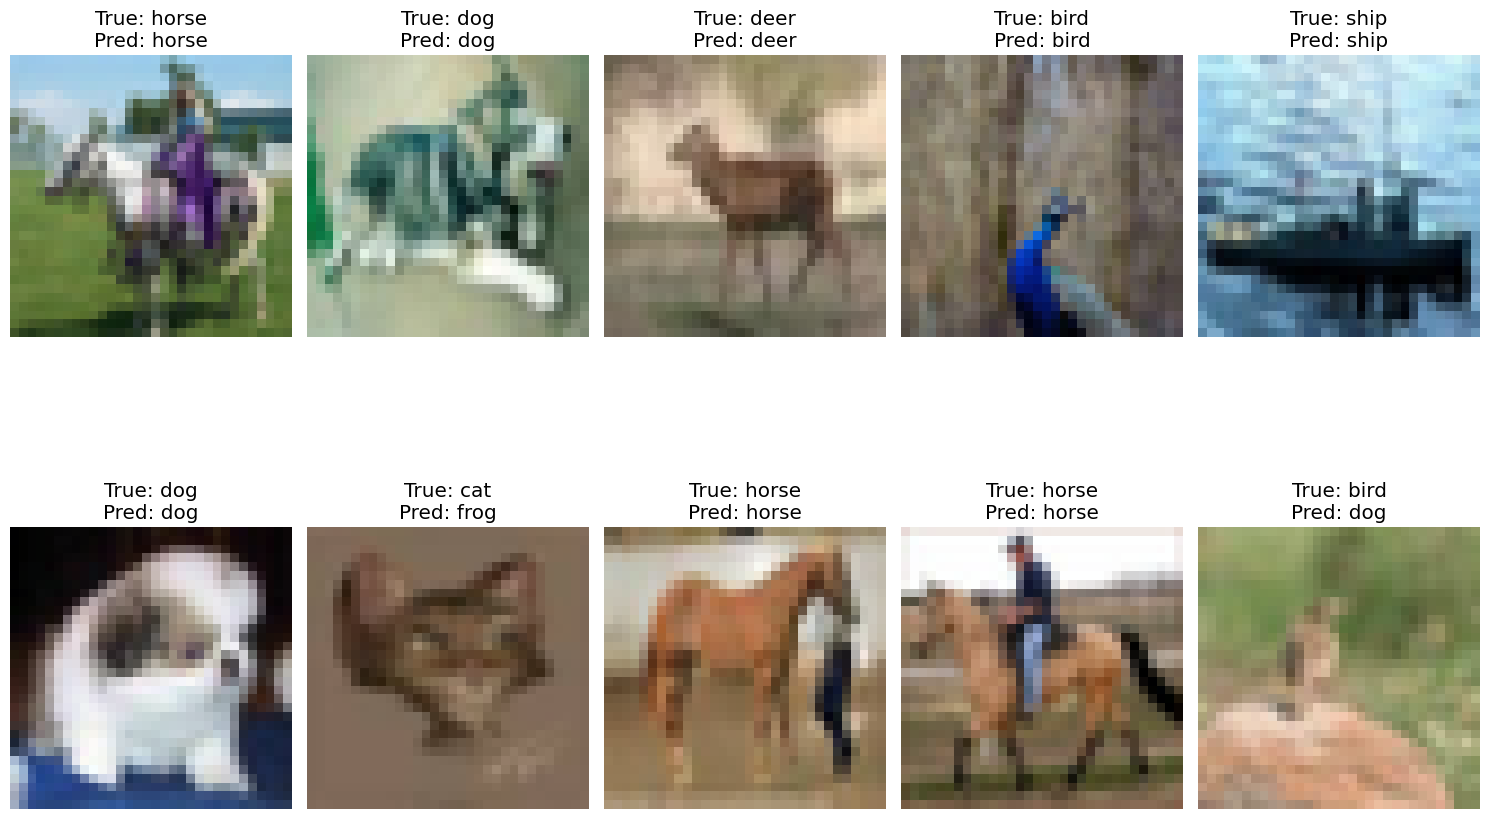

In [16]:
@torch.no_grad()
def visualize_predictions(model, dataloader, num_images=10):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 15))

    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        for i in range(images.size(0)):
            if images_shown >= num_images:
                break

            image = images[i].cpu().numpy().transpose((1, 2, 0))
            image = np.clip(
                image * np.array([0.229, 0.224, 0.225])
                + np.array([0.485, 0.456, 0.406]),
                0,
                1,
            )
            label = class_names[labels[i].item()]
            pred = class_names[preds[i].item()]

            plt.subplot(num_images // 5 + 1, 5, images_shown + 1)
            plt.imshow(image)
            plt.title(f"True: {label}\nPred: {pred}")
            plt.axis("off")
            images_shown += 1

        if images_shown >= num_images:
            break

    plt.tight_layout()
    plt.show()


visualize_predictions(model, testloader, num_images=10)

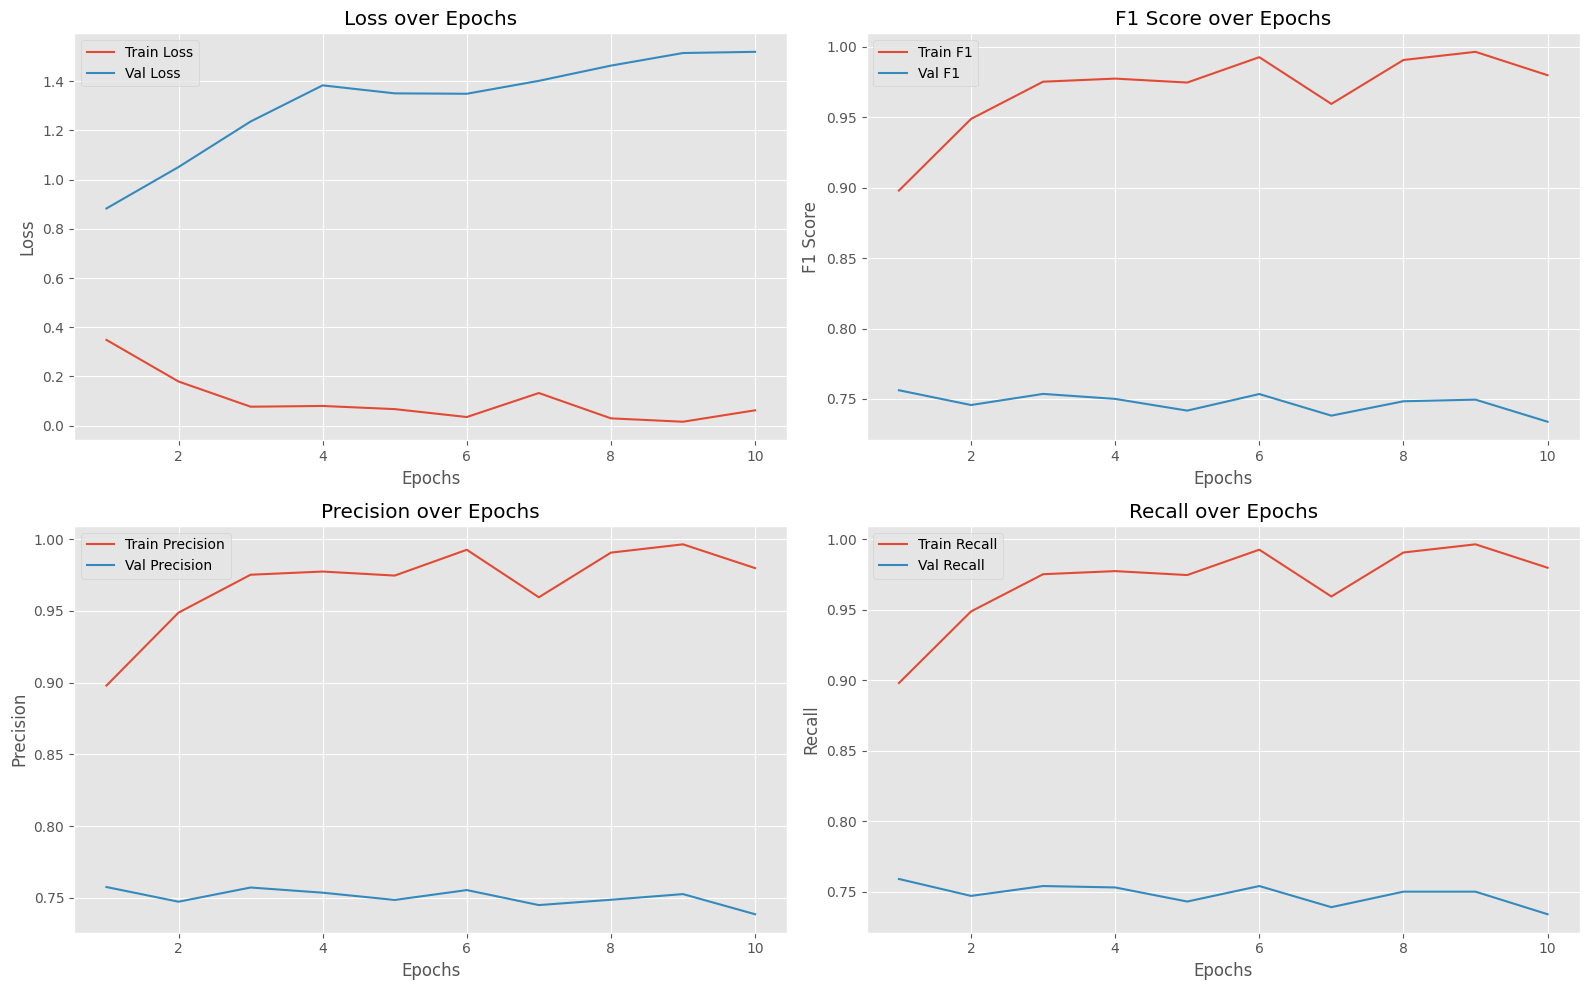

In [17]:
plt.style.use("ggplot")

# Построение графиков
epochs = range(1, config["epochs"] + 1)

plt.figure(figsize=(16, 10))

# График потерь
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# График F1-score
plt.subplot(2, 2, 2)
plt.plot(epochs, train_f1s, label="Train F1")
plt.plot(epochs, val_f1s, label="Val F1")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("F1 Score over Epochs")
plt.legend()

# График Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, train_precisions, label="Train Precision")
plt.plot(epochs, val_precisions, label="Val Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Precision over Epochs")
plt.legend()

# График Recall
plt.subplot(2, 2, 4)
plt.plot(epochs, train_recalls, label="Train Recall")
plt.plot(epochs, val_recalls, label="Val Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Recall over Epochs")
plt.legend()

plt.tight_layout()
plt.show()